In [ ]:
#-------------Shell Commands----------------------------------------------------------------------------------------------------------------------#

!pip uninstall -y gym gym-super-mario-bros                                                                                    
!pip install gym==0.26.2 gym-notices gym-super-mario-bros==7.4.0
!pip install stable-baselines3 gym_super_mario_bros nes_py
!pip install scipy 

In [100]:
#-------------Import necessary libraries---------------------------------------------------------------------------------------------------------#

import os
import csv
import gym
import gym_super_mario_bros
from gym.wrappers import FrameStack, GrayScaleObservation
from gym.spaces import Box
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# Numerical computation and Deep Learning
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Helpers
import random
from collections import deque
import matplotlib.pyplot as plt
import torchvision.transforms as T
import time
import imageio
from PIL import Image
import re

In [101]:
#-------------Dueling DQN Neural Network---------------------------------------------------------------------------------------------------------#

class DuelingDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Compute the output size after convolutional layers
        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size - 1) - 1) // stride + 1

        conv_h = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 8, 4), 4, 2), 3, 1)
        conv_w = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[2], 8, 4), 4, 2), 3, 1)
        linear_input_size = conv_w * conv_h * 64

        self.fc1 = nn.Linear(linear_input_size, 512)

        # Define the advantage and value streams
        self.advantage_stream = nn.Linear(512, num_actions)
        self.value_stream = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))

        # Separate into advantage and value streams
        advantage = self.advantage_stream(x)
        value = self.value_stream(x)

        # Combine advantage and value to get final Q values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

In [102]:
#-------------Define Wrappers---------------------------------------------------------------------------------------------------------#
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, truncated, info

class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation

class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

In [103]:
#-------------Configure environment---------------------------------------------------------------------------------------------------------#


env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0', apply_api_compatibility=True, render_mode="none")
env = JoypadSpace(env, SIMPLE_MOVEMENT)  # Limit actions to simple movement

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply wrappers: frame skipping, grayscale, resizing, and stacking frames
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

# Hyperparameters
state_space = env.observation_space.shape  # (4, 84, 84)
action_space = env.action_space.n

# Initialize Q-networks (policy and target) for Dueling DDQN (or DDQN)
policy_net = DuelingDQN((4, 84, 84), action_space).to(device)
target_net = DuelingDQN((4, 84, 84), action_space).to(device)

# target_net.load_state_dict(policy_net.state_dict())  # Synchronize networks
# target_net.eval()





In [104]:
#-------------Epsilon-greedy action selection---------------------------------------------------------------------------------------------------------#

def select_action(state, epsilon):
    if random.random() < epsilon:  # Explore
        return env.action_space.sample()
    else:  # Exploit (choose best action)
        with torch.no_grad():
            return policy_net(state).argmax().item()

# Create GIF from saved frames
def create_gif(frames, gif_path, fps=30):
    imageio.mimsave(gif_path, frames, fps=fps)

In [ ]:
#-------------Load the trained model for testing---------------------------------------------------------------------------------------------------------#


model_path = 'policy_net_weights_40000.pth'  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DuelingDQN((4, 84, 84), action_space).to(device)
#policy_net = DQN((4, 84, 84), action_space).to(device)
policy_net.load_state_dict(torch.load(model_path, map_location=device))
policy_net.eval()

# Initialize the Super Mario environment for testing
#env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', apply_api_compatibility=True, render_mode="human")
env = gym_super_mario_bros.make('SuperMarioBrosRandomStages-v0', stages=['1-4'], apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

# Preprocess the state for input to the model
def preprocess_state(state):
    state = np.ascontiguousarray(state)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    return state

# Testing loop for multiple episodes
num_episodes = 1

for episode in range(num_episodes):
    state, _ = env.reset()
    state = preprocess_state(state)
    done = False
    total_reward = 0

    # Episode loop
    while not done:
        action = select_action(state, epsilon=0.0)  # Greedy action selection
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = preprocess_state(next_state)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

env.close()


In [188]:
#---------Load GIFs---------------------------------------------------------------------------------------------------------#

model_path = 'policy_net_weights_26000.pth'
episode_number = re.search(r'\d+', model_path).group()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DuelingDQN((4, 84, 84), action_space).to(device)
policy_net.load_state_dict(torch.load(model_path, map_location=device))
policy_net.eval()

# Initialize Mario environment
#env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', apply_api_compatibility=True, render_mode="rgb_array")
env = gym_super_mario_bros.make('SuperMarioBros-1-4-v0', apply_api_compatibility=True, render_mode="rgb_array")
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)

# Preprocess state for the model
def preprocess_state(state):
    state = np.ascontiguousarray(state)
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    return state

# List to store frames for GIF creation
frames = []

# Start episode
state, _ = env.reset()
state = preprocess_state(state)
done = False
total_reward = 0

# Loop for recording episode frames
while not done:
    # Render and save the current frame
    img = env.render()
    img = Image.fromarray(img)
    img = img.resize((img.width * 4, img.height * 4), Image.NEAREST)  
    frames.append(np.array(img))

    # Select action using epsilon-greedy policy (for testing epsilon=0.00)
    action = select_action(state, epsilon=0.00)
    next_state, reward, terminated, truncated, _ = env.step(action)
    next_state = preprocess_state(next_state)
    done = terminated or truncated
    total_reward += reward
    state = next_state

# Close environment after episode
env.close()

# Create GIF from saved frames
#imageio.mimsave('mario_episode_duelingdqn_{episode_number}_11.gif', frames, fps=30)
gif_filename = f'mario_episode_duelingdqn_{episode_number}_14.gif'
imageio.mimsave(gif_filename, frames, fps=15)
print(f"GIF successfully created and saved as {gif_filename}!")

C:\Users\sfadm\AppData\Local\Temp\ipykernel_9852\3889188408.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy_net.load_state_dict(torch.load(model_path, map_locatio

GIF successfully created and saved as mario_episode_duelingdqn_26000_14.gif!


In [ ]:
#---------------Efficient shortcuts for intermediate data postprocessing using DuckDB S---------------------------------------------------------------------------------------------------------#

# type: ignore


# (i) Transfer the training log data from Google Colab for further analysis
INSERT INTO mario_data_dueling_14 
SELECT * FROM read_csv_auto('C:/Users/sfadm/Desktop/training_log_dueling_14 (50).txt', delim=','); 

DELETE FROM mario_data_dueling_14
WHERE Episode IN (
    SELECT Episode
    FROM mario_data_dueling_14
    GROUP BY Episode
    HAVING COUNT(*) > 1
)
AND rowid NOT IN (
    SELECT MIN(rowid)
    FROM mario_data_dueling_14
    GROUP BY Episode
); 

# Sanity check 
SELECT * FROM mario_data_dueling_14; 


# (ii) Determine the success rates across segmented blocks of 1.000 episodes

WITH Blocked_Episodes AS (
    SELECT 
        Episode,
        Success,
        Episode_Length,
        FLOOR(Episode / 1000) AS Block
    FROM 
        mario_data_dueling_14
),
Success_Per_Block AS (
    SELECT 
        Block,
        SUM(Success) AS Successful_Episodes,
        COUNT(*) AS Total_Episodes,
        SUM(Success) * 100.0 / COUNT(*) AS Success_Rate,
        AVG(Episode_Length) AS Average_Episode_Length
    FROM 
        Blocked_Episodes
    GROUP BY 
        Block
)
SELECT 
    Block * 1000 AS Block_Start_Episode, 
    Block * 1000 + 999 AS Block_End_Episode,
    Successful_Episodes, 
    Total_Episodes, 
    Success_Rate,
    Average_Episode_Length
FROM 
    Success_Per_Block
ORDER BY 
    Block; 

# (iii) Compute the moving averages for the last 100 episodes, along with the minimum and maximum moving averages over the same period, tracing back 
#       from the current episode. Subsequently, export the data to a CSV file for seamless plotting and visualization within this notebook later

COPY (
    WITH Moving_Avg_Window AS (
        SELECT 
            Episode, 
            Moving_Average,
            -- Define the window for the last 100 episodes
            MIN(Moving_Average) OVER (ORDER BY Episode ROWS BETWEEN 99 PRECEDING AND CURRENT ROW) AS min_moving_avg_100,
            MAX(Moving_Average) OVER (ORDER BY Episode ROWS BETWEEN 99 PRECEDING AND CURRENT ROW) AS max_moving_avg_100
        --FROM mario_data_dueling_11
          FROM mario_data_dueling_14
    )
    SELECT * FROM Moving_Avg_Window
) 
--TO 'dueling_moving_avg_stats.csv' WITH (HEADER, DELIMITER ','); 
  TO 'C:/Users/sfadm/Desktop/moving_avg_stats_dueling_14.csv' WITH (HEADER, DELIMITER ','); 



In [38]:
#---------Data postprocessing---------------------------------------------------------------------------------------------------------#

# type: ignore

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 1: Convert training_log.txt file to CSV with ANSI encoding
#------------------------------------------------------------------------------------------------------------------------------------#

# Use PowerShell to convert the training_log.txt file to a CSV format with ANSI encoding.
# This extracts the relevant training data from the Dueling network into a structured CSV format.

# Episode: 0, Total Reward: 782.0, Epsilon: 1.0
# Replay Buffer Memory:  306, Episode Length: 45, Step Count: 45
# Moving Average (Training):  782.0
# Episode: 1, Total Reward: 686.0, Epsilon: 0.9913970890487328
# Replay Buffer Memory:  594, Episode Length: 38, Step Count: 83
# Moving Average (Training):  734.0
# Episode: 2, Total Reward: 625.0, Epsilon: 0.985377738013741
# Replay Buffer Memory:  797, Episode Length: 51, Step Count: 134
# Moving Average (Training):  697.6666666666666
# ...

# PowerShell script to extract data from training_log.txt and save it as mario_data.csv
# Get-Content "C:\Users\sfadm\Desktop\dueling.txt" | ForEach-Object {
#     if ($_ -match 'Episode') {
#         $episode = ($_ -split ",")[0] -replace 'Episode: ', ''
#         $totalReward = ($_ -split ",")[1] -replace 'Total Reward: ', ''
#         $epsilon = ($_ -split ",")[2] -replace 'Epsilon: ', ''
#     }
#     elseif ($_ -match 'Replay Buffer Memory') {
#         $replayBuffer = ($_ -split ",")[0] -replace 'Replay Buffer Memory: ', ''
#         $episodeLength = ($_ -split ",")[1] -replace 'Episode Length: ', ''
#         $stepCount = ($_ -split ",")[2] -replace 'Step Count: ', ''
#     }
#     elseif ($_ -match 'Moving Average') {
#         $movingAverage = ($_ -split ":")[1].Trim()
#         "$episode,$totalReward,$epsilon,$replayBuffer,$episodeLength,$stepCount,$movingAverage" | Out-File "C:\Users\sfadm\Desktop\mario_data_dueling.csv" -Append -Encoding ASCII
#     }
# }


#------------------------------------------------------------------------------------------------------------------------------------#
# Step 2: Drop and recreate the table in DuckDB (or other)
#------------------------------------------------------------------------------------------------------------------------------------#

# Recreate the table in DuckDB (or any preferred SQL-based database system) to store the episode data from the Dueling network.

# DROP TABLE IF EXISTS mario_data_dueling_11;
# CREATE TABLE mario_data_dueling_11 (
#     Episode INTEGER, 
#     Total_Reward DOUBLE, 
#     Moving_Average DOUBLE
# );

# DROP TABLE IF EXISTS mario_data_dueling_14; 
# CREATE TABLE mario_data_dueling_14 (
#       Episode INTEGER, 
#       Total_Reward DOUBLE, 
#       Moving_Average DOUBLE,
#       Episode_Length INTEGER,
#       Step_Count    INTEGER,
#       Success       INTEGER
# ); 


# If step 1 is not necessary:

# Import data from training_log.txt into the table
# Adjust the delimiter if necessary, for example, if the file is space-separated
# INSERT INTO mario_data_dueling_11
# SELECT * FROM read_csv_auto('C:/Users/sfadm/Desktop/training_log.txt', delim=',');

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 3: Import the data from CSV into the mario_data_dueling_11 table
#------------------------------------------------------------------------------------------------------------------------------------#

# Use this SQL query to import the CSV data from the training log into the mario_data_dueling_11 table.
# This works seamlessly with DuckDB or other SQL-based databases.

# INSERT INTO mario_data_dueling_11
# SELECT * FROM read_csv_auto('C:/Users/sfadm/Desktop/dueling_data.csv');

INSERT INTO mario_data_dueling_14 
SELECT * FROM read_csv_auto('C:/Users/sfadm/Desktop/training_log_dueling_14.txt', delim=','); 

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 4: Remove duplicates from the table (sanity check)
#------------------------------------------------------------------------------------------------------------------------------------#

# As a sanity check, this query ensures the integrity of the dueling network data by removing duplicate episodes.
# The query ensures that only unique records are maintained in the table.

DELETE FROM mario_data_dueling_14
WHERE Episode IN (
    SELECT Episode
    FROM mario_data_dueling_14
    GROUP BY Episode
    HAVING COUNT(*) > 1
)
AND rowid NOT IN (
    SELECT MIN(rowid)
    FROM mario_data_dueling_14
    GROUP BY Episode
); 

# Sanity check 
SELECT * FROM mario_data_dueling_14; 

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 5: Compute success rate per block of 500 episodes for the Dueling network
#------------------------------------------------------------------------------------------------------------------------------------#

# This query calculates the success rate for the dueling network, dividing the episodes into blocks of 500.
# Each block's success rate is computed based on episodes where the total reward exceeds 3000.

# WITH Blocked_Episodes AS (
#     SELECT 
#         Episode,
#         Total_Reward,
#         FLOOR(Episode / 500) AS Block
#     FROM 
#         mario_data_dueling_11
# ),
# Success_Per_Block AS (
#     SELECT 
#         Block,
#         COUNT(CASE WHEN Total_Reward >= 3000 THEN 1 END) AS Successful_Episodes,
#         COUNT(*) AS Total_Episodes,
#         COUNT(CASE WHEN Total_Reward >= 3000 THEN 1 END) * 100.0 / COUNT(*) AS Success_Rate
#     FROM 
#         Blocked_Episodes
#     GROUP BY 
#         Block
# )
# SELECT 
#     Block * 500 AS Block_Start_Episode, 
#     Block * 500 + 499 AS Block_End_Episode,
#     Successful_Episodes, 
#     Total_Episodes, 
#     Success_Rate
# FROM 
#     Success_Per_Block
# ORDER BY 
#     Block;

# Or combine both:

WITH Blocked_Episodes AS (
    SELECT 
        Episode,
        Success,
        Episode_Length,
        FLOOR(Episode / 1000) AS Block
    FROM 
        mario_data_dueling_14
),
Success_Per_Block AS (
    SELECT 
        Block,
        SUM(Success) AS Successful_Episodes,
        COUNT(*) AS Total_Episodes,
        SUM(Success) * 100.0 / COUNT(*) AS Success_Rate,
        AVG(Episode_Length) AS Average_Episode_Length
    FROM 
        Blocked_Episodes
    GROUP BY 
        Block
)
SELECT 
    Block * 1000 AS Block_Start_Episode, 
    Block * 1000 + 999 AS Block_End_Episode,
    Successful_Episodes, 
    Total_Episodes, 
    Success_Rate,
    Average_Episode_Length
FROM 
    Success_Per_Block
ORDER BY 
    Block; 

#------------------------------------------------------------------------------------------------------------------------------------#
# Step 6: Create the table with moving averages, and calculate min/max over the last 100 episodes for the Dueling network
#------------------------------------------------------------------------------------------------------------------------------------#

# Create the table with moving averages, and calculate min/max over the last 100 episodes

COPY (
    WITH Moving_Avg_Window AS (
        SELECT 
            Episode, 
            Moving_Average,
            -- Define the window for the last 100 episodes
            MIN(Moving_Average) OVER (ORDER BY Episode ROWS BETWEEN 99 PRECEDING AND CURRENT ROW) AS min_moving_avg_100,
            MAX(Moving_Average) OVER (ORDER BY Episode ROWS BETWEEN 99 PRECEDING AND CURRENT ROW) AS max_moving_avg_100
        --FROM mario_data_dueling_11
          FROM mario_data_dueling_14
    )
    SELECT * FROM Moving_Avg_Window
) 
--TO 'dueling_moving_avg_stats.csv' WITH (HEADER, DELIMITER ','); 
  TO 'C:/Users/sfadm/Desktop/moving_avg_stats_dueling_14.csv' WITH (HEADER, DELIMITER ','); 



#------------------------------------------------------------------------------------------------------------------------------------#
# Additional potential stats algorithm: Detect streaks of high rewards in the Dueling network
#------------------------------------------------------------------------------------------------------------------------------------#

# This query identifies streaks of consecutive episodes in the dueling network where rewards exceed a certain threshold (here 3040).
# The query detects these streaks and outputs the length of each streak, along with the associated reward data.

# WITH episode_streaks AS (
#     SELECT
#         Episode,
#         Total_Reward,
#         CASE 
#             WHEN Total_Reward > 3040 THEN 1 
#             ELSE 0 
#         END AS reward_over_3000,
#         ROW_NUMBER() OVER (ORDER BY Episode) -
#         ROW_NUMBER() OVER (PARTITION BY CASE WHEN Total_Reward > 3040 THEN 1 ELSE 0 END ORDER BY Episode) AS streak_identifier
#     FROM
#         mario_data_dueling_11
# ),
# streak_summary AS (
#     SELECT
#         MIN(Episode) AS episode_start,
#         MAX(Episode) AS episode_end,
#         COUNT(*) AS streak_length,
#         STRING_AGG(Total_Reward::TEXT, ',') AS total_reward_array
#     FROM
#         episode_streaks
#     WHERE
#         reward_over_3000 = 1
#     GROUP BY
#         streak_identifier
# )
# SELECT 
#     episode_start AS "Episode Start",
#     episode_end AS "Episode End",
#     streak_length AS "Streak Length",
#     total_reward_array AS "Total Reward Array"
# FROM
#     streak_summary
# ORDER BY
#     streak_length DESC;


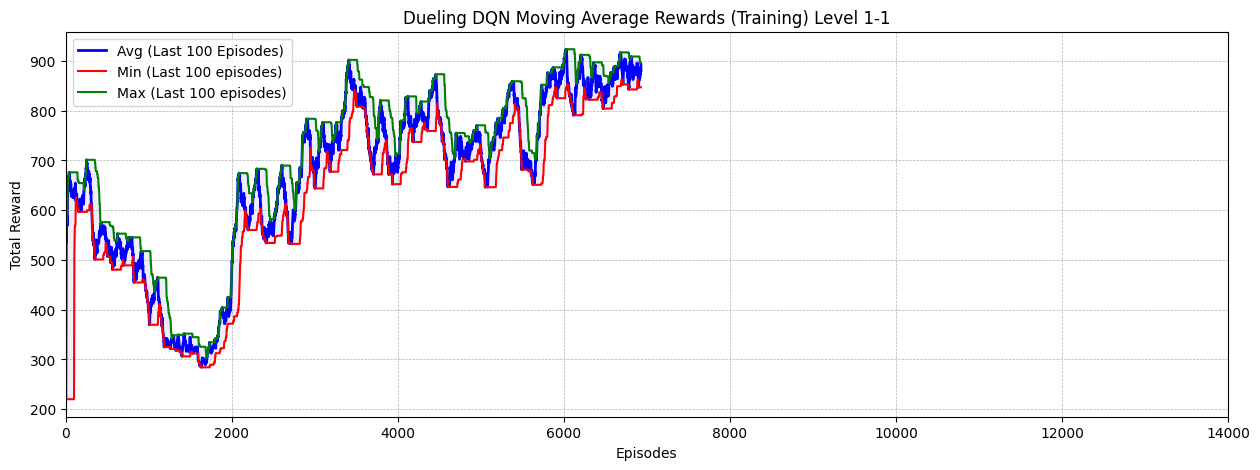

In [169]:
#-------Moving Averages [1,1]---------------------------------------------------------------------------------------------------------#


import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('dueling_moving_avg_stats.csv')

# Extract data for plotting
episode_numbers = df['Episode']
moving_average_training_smoothed = df['Moving_Average']
min_moving_average_training = df['min_moving_avg_100']
max_moving_average_training = df['max_moving_avg_100']

# Plot the result
plt.figure(figsize=(15, 5))

# Plot smoothed Training Moving Average with sliding min and max
plt.plot(episode_numbers, moving_average_training_smoothed, 'b-', label='Avg (Last 100 Episodes)', linewidth=2)
plt.plot(episode_numbers, min_moving_average_training, 'r-', linewidth=1.5, label='Min (Last 100 episodes)')
plt.plot(episode_numbers, max_moving_average_training, 'g-', linewidth=1.5, label='Max (Last 100 episodes)')

# Fill the area between min and max with lighter transparency
plt.fill_between(episode_numbers, min_moving_average_training, max_moving_average_training, facecolor='blue', alpha=0.07)

# Set x-axis limit to 14,000 episodes
plt.xlim([0, 14000])

# Titles and labels
plt.title('Dueling DQN Moving Average Rewards (Training) Level 1-1')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('Dueling_DQN_reward_moving_avg.png', dpi=300)
plt.show()


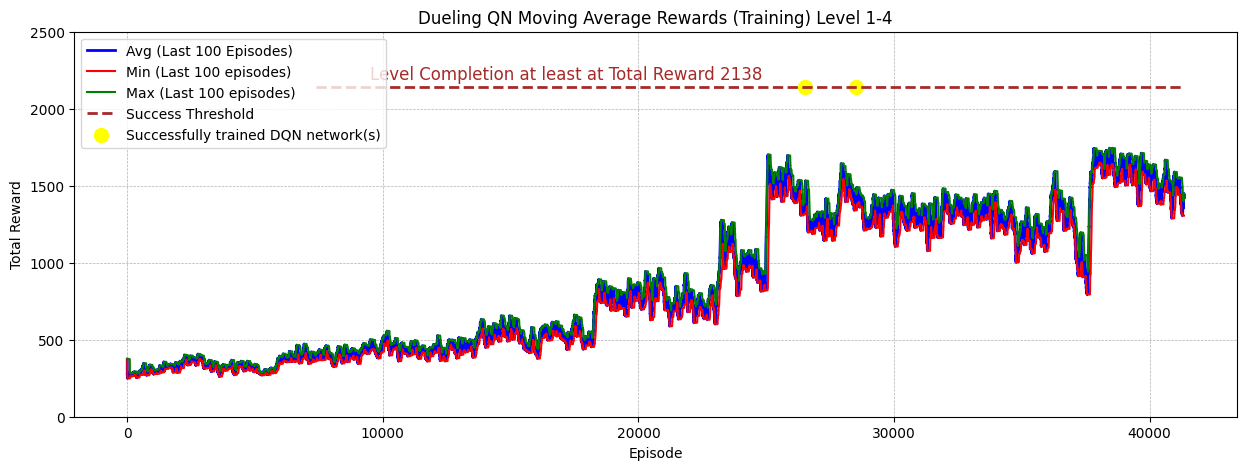

In [149]:
#-------Moving Averages [1,4]---------------------------------------------------------------------------------------------------------#

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
#df = pd.read_csv('moving_avg_stats_double.csv')
df = pd.read_csv('moving_avg_stats_dueling_14.csv')

# Extract data for plotting
episode_numbers = df['Episode']
moving_average_training_smoothed = df['Moving_Average']
min_moving_average_training = df['min_moving_avg_100']
max_moving_average_training = df['max_moving_avg_100']

# Plot the result
plt.figure(figsize=(15, 5))

# Plot smoothed Training Moving Average with sliding min and max
plt.plot(episode_numbers, moving_average_training_smoothed, 'b-', label='Avg (Last 100 Episodes)', linewidth=2)
plt.plot(episode_numbers, min_moving_average_training, 'r-', linewidth=1.5, label='Min (Last 100 episodes)')
plt.plot(episode_numbers, max_moving_average_training, 'g-', linewidth=1.5, label='Max (Last 100 episodes)')

# Fill the area between min and max with lighter transparency
plt.fill_between(episode_numbers, min_moving_average_training, max_moving_average_training, facecolor='blue', alpha=0.07)

# Add a horizontal line at the success threshold (2138)
plt.plot([7380, episode_numbers.max()], [2138, 2138], color='brown', linestyle='--', linewidth=2, label='Success Threshold')
plt.text(9500, 2190, 'Level Completion at least at Total Reward 2138', color='brown', fontsize=12)
plt.ylim(0, 2500)

# Yellow point at episode 26,500 indicating success
plt.scatter(26500, 2138, color='yellow', s=100, label='Successfully trained DQN network(s)')
plt.scatter(28500, 2138, color='yellow', s=100)

# Titles and labels
plt.title('Dueling QN Moving Average Rewards (Training) Level 1-4')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.savefig('Double_DQN_reward_moving_avg_11.png', dpi=300)
plt.savefig('Dueling_DQN_reward_moving_avg_14.png', dpi=300)

plt.show()


Processing line: 12500:
Current weight: 12500
Processing line: Episode 1, Total Reward: 1704.0
Parsed: Network=12500, Episode=1, Total Reward=1704.0
Processing line: Episode 2, Total Reward: 1586.0
Parsed: Network=12500, Episode=2, Total Reward=1586.0
Processing line: Episode 3, Total Reward: 1924.0
Parsed: Network=12500, Episode=3, Total Reward=1924.0
Processing line: Episode 4, Total Reward: 1046.0
Parsed: Network=12500, Episode=4, Total Reward=1046.0
Processing line: Episode 5, Total Reward: 3013.0
Parsed: Network=12500, Episode=5, Total Reward=3013.0
Processing line: Episode 6, Total Reward: 3037.0
Parsed: Network=12500, Episode=6, Total Reward=3037.0
Processing line: Episode 7, Total Reward: 2930.0
Parsed: Network=12500, Episode=7, Total Reward=2930.0
Processing line: Episode 8, Total Reward: 1050.0
Parsed: Network=12500, Episode=8, Total Reward=1050.0
Processing line: Episode 9, Total Reward: 2358.0
Parsed: Network=12500, Episode=9, Total Reward=2358.0
Processing line: Episode 10

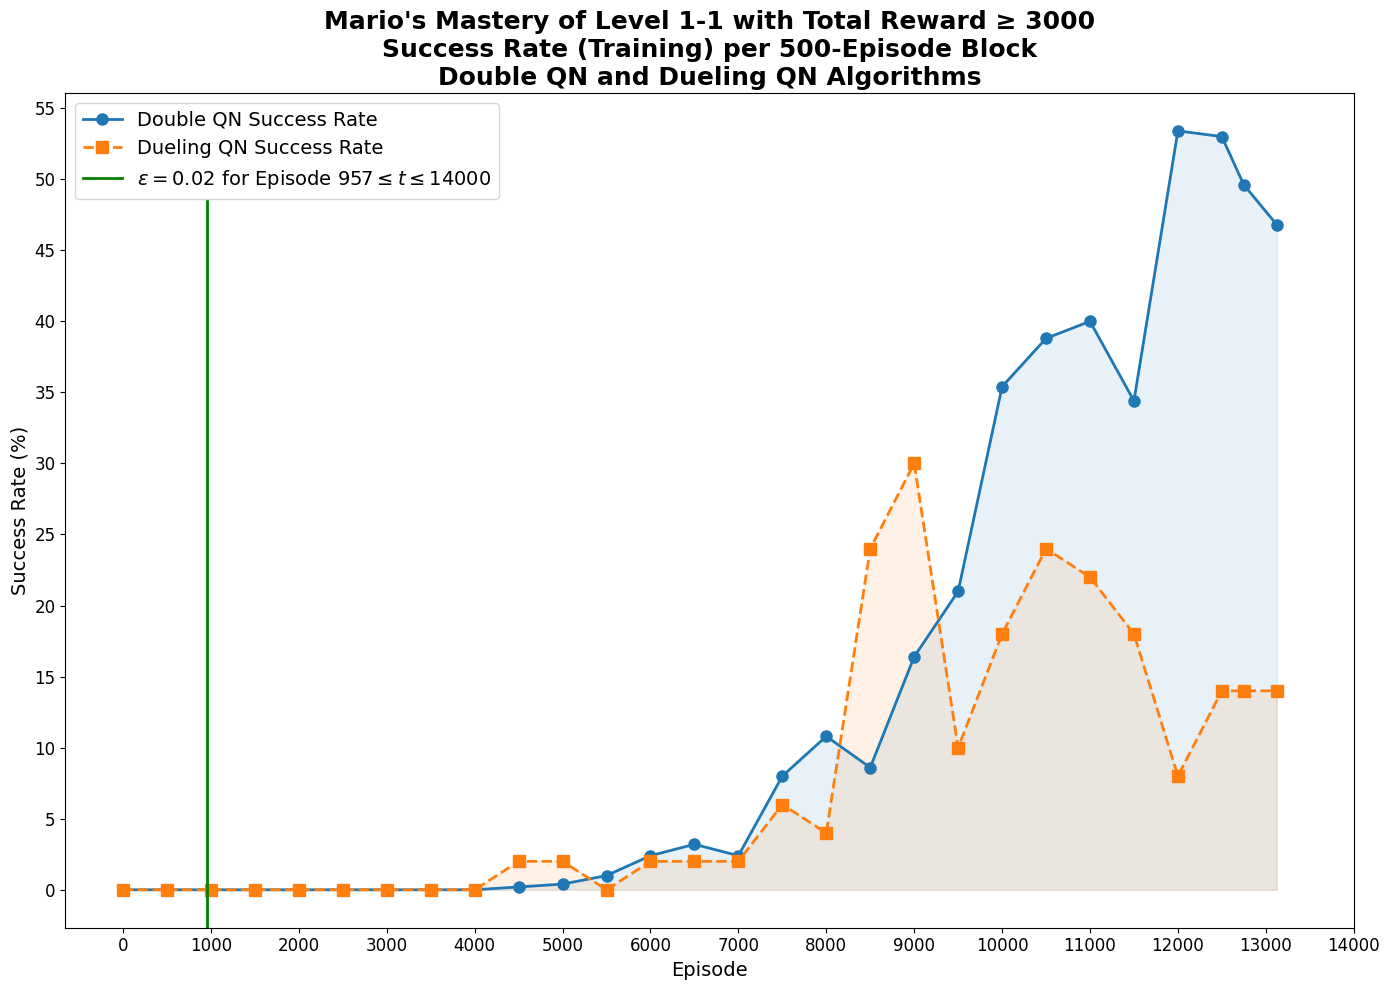

In [ ]:
#-------------------------------Success Rates[1,1]---------------------------------------------------------------------------------#


import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np


# Define the directory and file paths
directory = Path(r'C:\Users\sfadm\Desktop\trainingDueling_Level11_nr')
input_file = 'dueling_success_rates_11.txt'  # Ensure this is the correct file
file_path = directory / input_file
output_csv = directory / 'success_rate_per_network.csv'

# Check if the file exists
if not file_path.exists():
    print(f"File not found at: {file_path}")
    sys.exit()

# Initialize an empty list to store the data
data = []

# Read the file and process the data
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        current_weight = None

        for line in file:
            line = line.strip()
            if not line:
                continue

            # Debugging: print each line
            print(f"Processing line: {line}")

            # Check if the line is a weight value
            if line.endswith(':'):
                try:
                    current_weight = int(line[:-1])  # Remove the colon and store the weight
                    print(f"Current weight: {current_weight}")
                except ValueError:
                    print(f"Invalid weight format: {line}")
                    continue
            else:
                try:
                    # Parse the episode and reward information
                    episode_info, reward_info = line.split(', Total Reward:')
                    episode = int(episode_info.split('Episode ')[1])
                    total_reward = float(reward_info.strip())

                    # Append the parsed data to the list
                    print(f"Parsed: Network={current_weight}, Episode={episode}, Total Reward={total_reward}")
                    data.append([current_weight, episode, total_reward])
                except Exception as parse_error:
                    print(f"Error parsing line: {line} | {parse_error}")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    sys.exit()

# Convert the list to a Pandas DataFrame
df = pd.DataFrame(data, columns=['Network', 'Episode', 'Total_Reward'])

# Define success threshold
SUCCESS_THRESHOLD = 3000

# Create 'Success' column
df['Success'] = df['Total_Reward'] >= SUCCESS_THRESHOLD

# Group by 'Network' and aggregate
success_stats = df.groupby('Network').agg(
    Total_Episodes=('Episode', 'count'),
    Successful_Episodes=('Success', 'sum')
).reset_index()

# Calculate Success Rate
success_stats['Success_Rate (%)'] = (success_stats['Successful_Episodes'] / success_stats['Total_Episodes']) * 100

# Display the success rates
print("Success Rate per Network:")
print(success_stats)

# Save the success rates to a CSV file
try:
    success_stats.to_csv(output_csv, index=False)
    print(f"Success rates saved to: {output_csv}")
except Exception as e:
    print(f"An error occurred while saving the CSV file: {e}")

# Optional: Visualize the success rates
try:
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Network',
        y='Success_Rate (%)',
        data=success_stats,
        palette='viridis'
    )
    plt.title('Success Rate per Network', fontsize=16)
    plt.xlabel('Network', fontsize=14)
    plt.ylabel('Success Rate (%)', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"An error occurred while generating the plot: {e}")


#---------------------------------------Part 2 combining data with double------------------------------------------------

# --- Step 1: Load and Process Dueling QN Data ---

# Define the directory and file paths
directory = r'C:\Users\sfadm\Desktop\trainingDueling_Level11_nr'
input_file_csv = 'success_rate_per_network.csv'  # Ensure this is the correct file
file_path_csv = os.path.join(directory, input_file_csv)

# Check if the success rates CSV exists
if not os.path.exists(file_path_csv):
    print(f"File not found at: {file_path_csv}")
    sys.exit()

# Load the success rates DataFrame
dueling_success_stats = pd.read_csv(file_path_csv)

# Display the DataFrame
print("Dueling QN Success Rates:")
print(dueling_success_stats)

# Rename 'Network' to 'Block' for clarity, if necessary
if 'Network' in dueling_success_stats.columns:
    dueling_success_stats.rename(columns={'Network': 'Block'}, inplace=True)

# Sort the DataFrame by 'Block' to ensure correct order
dueling_success_stats = dueling_success_stats.sort_values(by='Block').reset_index(drop=True)

# Extract the Success Rates
success_rates = dueling_success_stats['Success_Rate (%)'].values

# --- Step 2: Compute Averaged Success Rates for Dueling QN ---

# Compute the average of two consecutive Success Rates
averaged_dueling_success_rates = (success_rates[:-1] + success_rates[1:]) / 2

print(f"\nAveraged Dueling QN Success Rates (25 entries):")
print(averaged_dueling_success_rates)

# --- Step 3: Define Corresponding mid_blocks for Averaged Data ---

# Extract the Block values
blocks = dueling_success_stats['Block'].values

# Compute the averaged mid_blocks (midpoint between two consecutive blocks)
# Adding 250 to center within the 500-episode block
averaged_mid_blocks = (blocks[:-1] + blocks[1:]) / 2 + 250

print(f"\nAveraged Mid Blocks (25 entries):")
print(averaged_mid_blocks)

# --- Step 4: Align Dueling QN Data to Match Double QN Entries (28) ---

# Original Double QN success rates (28 entries)
double_qn_success_rates = np.array([
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 
    0.4, 1.0, 2.4, 3.2, 2.4, 8.0, 10.8, 8.6, 16.4, 21.0, 
    35.4, 38.8, 40.0, 34.4, 53.4, 53.0, 49.6, 46.8
])

print(f"\nOriginal Double QN Success Rates (28 entries):")
print(double_qn_success_rates)

# Number of entries needed
desired_length = 28
current_length = len(averaged_dueling_success_rates)

if current_length < desired_length:
    padding_needed = desired_length - current_length
    # Pad equally at the beginning and end
    pad_front = padding_needed // 2
    pad_back = padding_needed - pad_front
    # Use the first and last averaged success rates for padding
    padded_dueling_success_rates = np.pad(
        averaged_dueling_success_rates, 
        (pad_front, pad_back), 
        'edge'
    )
elif current_length > desired_length:
    # If there are more entries than needed, truncate
    padded_dueling_success_rates = averaged_dueling_success_rates[:desired_length]
else:
    padded_dueling_success_rates = averaged_dueling_success_rates

print(f"\nPadded Dueling QN Success Rates (28 entries):")
print(padded_dueling_success_rates)

if len(averaged_mid_blocks) < desired_length:
    padding_needed = desired_length - len(averaged_mid_blocks)
    # Pad equally at the beginning and end
    pad_front = padding_needed // 2
    pad_back = padding_needed - pad_front
    # Calculate new mid_blocks by extending the first and last blocks
    new_front = averaged_mid_blocks[0] - 500 * pad_front
    new_back = averaged_mid_blocks[-1] + 500 * pad_back
    front_blocks = np.linspace(new_front, averaged_mid_blocks[0]-250, pad_front, endpoint=False)
    back_blocks = np.linspace(averaged_mid_blocks[-1]+250, new_back, pad_back, endpoint=False)
    padded_mid_blocks = np.concatenate([front_blocks, averaged_mid_blocks, back_blocks])
else:
    padded_mid_blocks = averaged_mid_blocks[:desired_length]

print(f"\nPadded Mid Blocks (28 entries):")
print(padded_mid_blocks)

# --- Step 5: Plotting Both Success Rates ---

plt.figure(figsize=(14, 10))

# Plot the Double QN success rate
plt.plot(
    padded_mid_blocks,
    double_qn_success_rates,
    marker='o',
    linestyle='-',
    color='#1f77b4',
    linewidth=2,
    markersize=8,
    label='Double QN Success Rate'
)

# Plot the Averaged Dueling QN success rate
plt.plot(
    padded_mid_blocks,
    padded_dueling_success_rates,
    marker='s',
    linestyle='--',
    color='#ff7f0e',
    linewidth=2,
    markersize=8,
    label='Dueling QN Success Rate'
)

# Fill between for Double QN
plt.fill_between(
    padded_mid_blocks,
    double_qn_success_rates,
    color='#1f77b4',
    alpha=0.1
)

# Fill between for Dueling QN
plt.fill_between(
    padded_mid_blocks,
    padded_dueling_success_rates,
    color='#ff7f0e',
    alpha=0.1
)

# Green vertical line for Episode 957
plt.axvline(
    x=957,
    ymin=0,
    ymax=0.87,
    color='green',
    linestyle='-',
    linewidth=2,
    label=r'$\epsilon = 0.02 \ \mathrm{for} \ \mathrm{Episode} \ 957 \leq t \leq 14000 $'
)

#Split the title into three lines without background highlighting
plt.title(
    "Mario's Mastery of Level 1-1 with Total Reward ≥ 3000\n"
    "Success Rate (Training) per 500-Episode Block\n"
    "Double QN and Dueling QN Algorithms",
    fontsize=18,
    fontweight='bold',
    loc='center',
    color='black'
)


# X and Y axis labels
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Success Rate (%)", fontsize=14)

# X-ticks: set based on the range of padded_mid_blocks
plt.xticks(
    ticks=np.arange(0, max(padded_mid_blocks) + 1000, 1000),
    fontsize=12
)

# Y-ticks: in 5% increments up to the maximum success rate
plt.yticks(
    ticks=np.arange(0, max(padded_dueling_success_rates.max(), double_qn_success_rates.max()) + 5, 5),
    fontsize=12
)

# Remove the grid
plt.grid(False)

# Adjust the legend and layout
plt.legend(fontsize=14, loc='upper left')
plt.tight_layout()

# Save the plot as a PNG image (optional)
output_plot = os.path.join(directory, 'success_rates_comparison.png')
plt.savefig(output_plot, dpi=300)
print(f"\nPlot saved to: {output_plot}")

# Show the plot
plt.show()


In [ ]:
#-------------------------------Success Rates[1,4]---------------------------------------------------------------------------------#



mid_blocks = np.array([500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500, 9500, 
                               10500, 11500, 12500, 13500, 14500, 15500, 16500, 17500, 
                               18500, 19500, 20500, 21500, 22500, 23500, 24500, 25500, 
                               26500, 27500, 28500, 29500, 30500])
success_rates = np.array([0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 
                                  0.2, 0.0, 0.1, 0.0, 0.2, 0.1, 0.5, 1.2, 1.9, 1.3, 
                                  3.3, 4.6, 6.1, 6.1, 4.1, 12.5, 10.5, 11.5, 12.0, 8.3, 8.30188679245283])


plt.figure(figsize=(12, 8))
plt.plot(mid_blocks, success_rates, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, label='Success Rate')


plt.fill_between(mid_blocks, success_rates, color='#1f77b4', alpha=0.1)

# Green line for Episode 6327
plt.axvline(x=6327, ymin=0, ymax=0.886, color='green', linestyle='-', linewidth=2, label=r'$\epsilon = 0.02 \ \mathrm{for} \ \mathrm{Episode} \ 6327 \leq t \leq 30529$')

# Title with a three-line heading
plt.title("Mario's Mastery of Level 1-4 with Total Reward ≥ 2138\nSuccess Rate (Training) per 1000-Episode Block", fontsize=16, fontweight='bold', loc='center', color='black')

# Highlight "Dueling DQN Algorithm" with a yellow box in the top line
highlight_text = "Dueling DQN Algorithm"
plt.text(0.5, 1.12, highlight_text, fontsize=16, fontweight='bold', color='black', backgroundcolor='yellow', transform=plt.gca().transAxes, ha='center')

# X and Y axis labels
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Success Rate (%)", fontsize=12)

# X-ticks: generally in 5000 steps for visibility
x_ticks = np.arange(0, 31000, 5000)
plt.xticks(x_ticks, fontsize=10)
plt.yticks(np.arange(0, 15, step=1), fontsize=10)

# Remove the grid
plt.grid(False)

# Adjust the legend and layout
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()



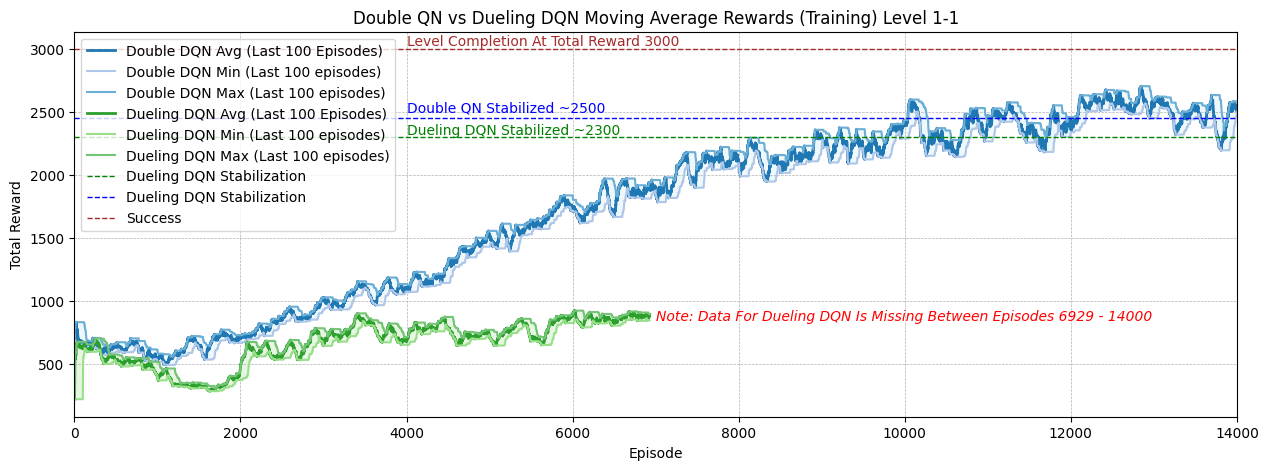

In [148]:
#---------------Dueling vs Double---------------------------------------------------------------------------------------------------------#


import pandas as pd
import matplotlib.pyplot as plt

# Load the Double DQN CSV file
df_double = pd.read_csv('moving_avg_stats_ddqn.csv')

# Load the Dueling DQN CSV file
df_dueling = pd.read_csv('dueling_moving_avg_stats.csv')

# Extract data for Double DQN
episode_numbers_double = df_double['Episode']
moving_average_training_smoothed_double = df_double['Moving_Average']
min_moving_average_training_double = df_double['min_moving_avg_100']
max_moving_average_training_double = df_double['max_moving_avg_100']

# Extract data for Dueling DQN
episode_numbers_dueling = df_dueling['Episode']
moving_average_training_smoothed_dueling = df_dueling['Moving_Average']
min_moving_average_training_dueling = df_dueling['min_moving_avg_100']
max_moving_average_training_dueling = df_dueling['max_moving_avg_100']

# Plot the result
plt.figure(figsize=(15, 5))

# Plot Double DQN with blue color scheme
plt.plot(episode_numbers_double, moving_average_training_smoothed_double, color='#1f77b4', label='Double DQN Avg (Last 100 Episodes)', linewidth=2)
plt.plot(episode_numbers_double, min_moving_average_training_double, color='#aec7e8', linewidth=1.5, label='Double DQN Min (Last 100 episodes)')
plt.plot(episode_numbers_double, max_moving_average_training_double, color='#6baed6', linewidth=1.5, label='Double DQN Max (Last 100 episodes)')
plt.fill_between(episode_numbers_double, min_moving_average_training_double, max_moving_average_training_double, facecolor='#c7e9f1', alpha=0.3)

# Plot Dueling DQN with green color scheme
plt.plot(episode_numbers_dueling, moving_average_training_smoothed_dueling, color='#2ca02c', label='Dueling DQN Avg (Last 100 Episodes)', linewidth=2)
plt.plot(episode_numbers_dueling, min_moving_average_training_dueling, color='#98df8a', linewidth=1.5, label='Dueling DQN Min (Last 100 episodes)')
plt.plot(episode_numbers_dueling, max_moving_average_training_dueling, color='#74c476', linewidth=1.5, label='Dueling DQN Max (Last 100 episodes)')
plt.fill_between(episode_numbers_dueling, min_moving_average_training_dueling, max_moving_average_training_dueling, facecolor='#b2e2a1', alpha=0.3)

# Add a short horizontal line for the Dueling DQN stabilization point at 2300 avg around episode 13000
plt.hlines(y=2300, xmin=0, xmax=14000, color='green', linestyle='--', linewidth=1, label='Dueling DQN Stabilization')
plt.text(4000, 2500, 'Double QN Stabilized ~2500', color='blue')

# Add a short horizontal line for the Dueling DQN stabilization point at 2300 avg around episode 13000
plt.hlines(y=2450, xmin=0, xmax=14000, color='blue', linestyle='--', linewidth=1, label='Dueling DQN Stabilization')
plt.text(4000, 2320, 'Dueling DQN Stabilized ~2300', color='green')

# Add a short horizontal line for the Dueling DQN stabilization point at 2300 avg around episode 13000
plt.hlines(y=3000, xmin=0, xmax=14000, color='brown', linestyle='--', linewidth=1, label='Success')
plt.text(4000, 3030, 'Level Completion At Total Reward 3000', color='brown')


# Notice for missing data in Dueling DQN
plt.text(7000, 850, 'Note: Data For Dueling DQN Is Missing Between Episodes 6929 - 14000', fontsize=10, color='red', style='italic')

# Set x-axis limit to 14,000 episodes for Dueling DQN
plt.xlim([0, 14000])

# Titles and labels
plt.title('Double QN vs Dueling DQN Moving Average Rewards (Training) Level 1-1')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('Double_vs_Dueling_DQN_reward_moving_avg.png', dpi=300)
plt.show()


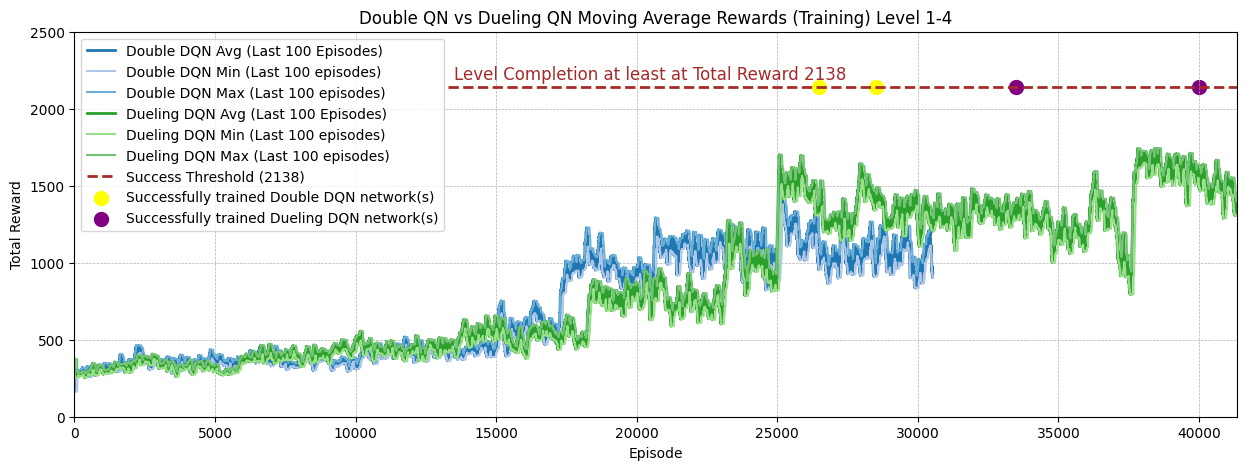

In [181]:
#--------------------------------------------------Moving Averages Dueling vs Double v[1,4]-------------------------------------------------------------------#

import pandas as pd
import matplotlib.pyplot as plt

# Load the Double DQN CSV file
df_double = pd.read_csv('moving_avg_stats_double_14.csv')

# Load the Dueling DQN CSV file
df_dueling = pd.read_csv('moving_avg_stats_dueling_14.csv')

# Extract data for Double DQN
episode_numbers_double = df_double['Episode']
moving_average_training_smoothed_double = df_double['Moving_Average']
min_moving_average_training_double = df_double['min_moving_avg_100']
max_moving_average_training_double = df_double['max_moving_avg_100']

# Extract data for Dueling DQN
episode_numbers_dueling = df_dueling['Episode']
moving_average_training_smoothed_dueling = df_dueling['Moving_Average']
min_moving_average_training_dueling = df_dueling['min_moving_avg_100']
max_moving_average_training_dueling = df_dueling['max_moving_avg_100']

# Plot the result
plt.figure(figsize=(15, 5))

# Plot Double DQN with blue color scheme
plt.plot(episode_numbers_double, moving_average_training_smoothed_double, color='#1f77b4', label='Double DQN Avg (Last 100 Episodes)', linewidth=2)
plt.plot(episode_numbers_double, min_moving_average_training_double, color='#aec7e8', linewidth=1.5, label='Double DQN Min (Last 100 episodes)')
plt.plot(episode_numbers_double, max_moving_average_training_double, color='#6baed6', linewidth=1.5, label='Double DQN Max (Last 100 episodes)')
plt.fill_between(episode_numbers_double, min_moving_average_training_double, max_moving_average_training_double, facecolor='#c7e9f1', alpha=0.3)

# Plot Dueling DQN with green color scheme
plt.plot(episode_numbers_dueling, moving_average_training_smoothed_dueling, color='#2ca02c', label='Dueling DQN Avg (Last 100 Episodes)', linewidth=2)
plt.plot(episode_numbers_dueling, min_moving_average_training_dueling, color='#98df8a', linewidth=1.5, label='Dueling DQN Min (Last 100 episodes)')
plt.plot(episode_numbers_dueling, max_moving_average_training_dueling, color='#74c476', linewidth=1.5, label='Dueling DQN Max (Last 100 episodes)')
plt.fill_between(episode_numbers_dueling, min_moving_average_training_dueling, max_moving_average_training_dueling, facecolor='#b2e2a1', alpha=0.3)

# Add a horizontal line for the success threshold (2138)
plt.hlines(y=2138, xmin=13300, xmax=max(episode_numbers_double.max(), episode_numbers_dueling.max()), color='brown', linestyle='--', linewidth=2, label='Success Threshold (2138)')
plt.text(13500, 2190, 'Level Completion at least at Total Reward 2138', color='brown', fontsize=12)

# Set y-axis limit to 2500 to give more space
plt.ylim(0, 2500)

# Set x-axis limit to fit the number of episodes
plt.xlim([0, max(episode_numbers_double.max(), episode_numbers_dueling.max())])

plt.scatter(26500, 2138, color='yellow', s=100, label='Successfully trained Double DQN network(s)')
plt.scatter(28500, 2138, color='yellow', s=100)

# Purple point for Dueling DQN
plt.scatter(33500, 2138, color='purple', s=100, label='Successfully trained Dueling DQN network(s)')
plt.scatter(40000, 2138, color='purple', s=100)

# Titles and labels
plt.title('Double QN vs Dueling QN Moving Average Rewards (Training) Level 1-4')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot
plt.savefig('Double_vs_Dueling_DQN_reward_moving_avg_14.png', dpi=300)
plt.show()


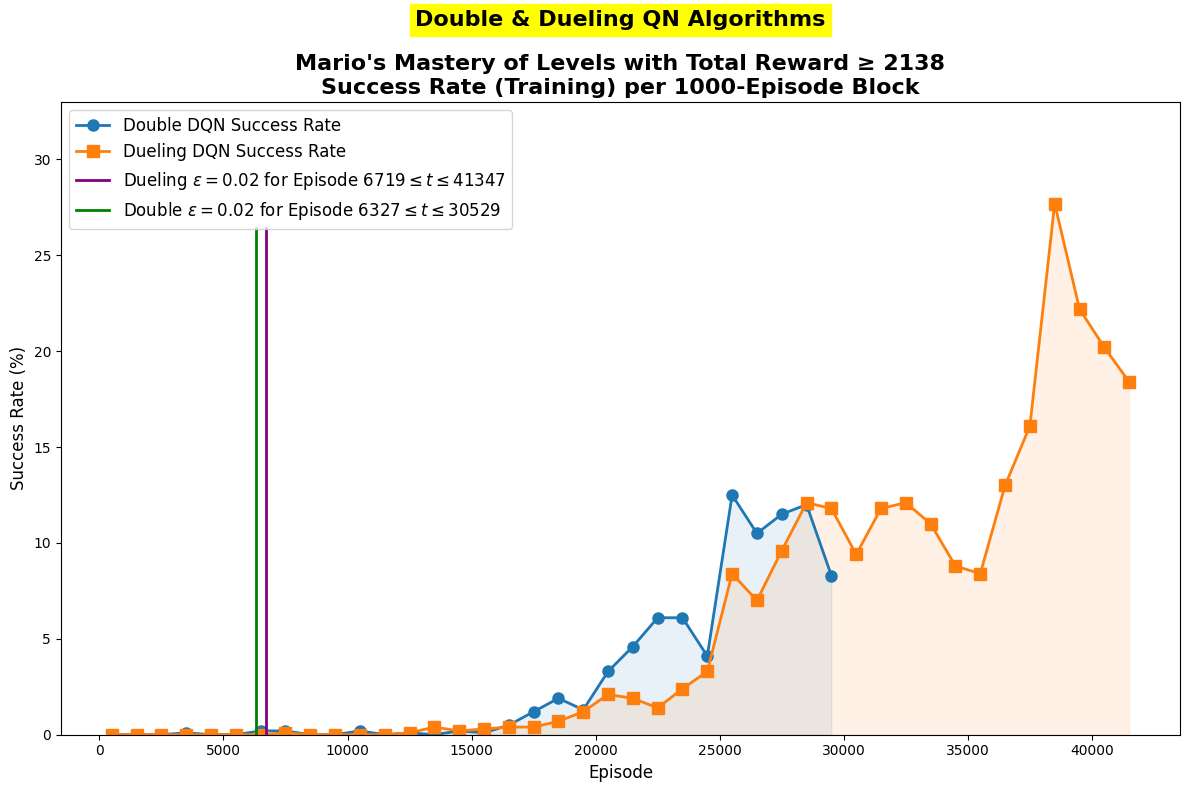

In [162]:
#---------------------------------------------Dueling and Double Success Rates v[1,4]---------------------------------------------------------------------------#

import matplotlib.pyplot as plt
import numpy as np

# Double DQN blocks and success rates (up to 30 blocks)
double_mid_blocks = np.array([500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500, 9500, 
                              10500, 11500, 12500, 13500, 14500, 15500, 16500, 17500, 
                              18500, 19500, 20500, 21500, 22500, 23500, 24500, 25500, 
                              26500, 27500, 28500, 29500])
double_success_rates = np.array([0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 
                                 0.2, 0.0, 0.1, 0.0, 0.2, 0.1, 0.5, 1.2, 1.9, 1.3, 
                                 3.3, 4.6, 6.1, 6.1, 4.1, 12.5, 10.5, 11.5, 12.0, 8.3])

# Dueling DQN success rates for more blocks (42 blocks, matching the table you provided)
dueling_mid_blocks = np.array([500, 1500, 2500, 3500, 4500, 5500, 6500, 7500, 8500, 9500, 
                               10500, 11500, 12500, 13500, 14500, 15500, 16500, 17500, 18500, 19500, 
                               20500, 21500, 22500, 23500, 24500, 25500, 26500, 27500, 28500, 29500, 
                               30500, 31500, 32500, 33500, 34500, 35500, 36500, 37500, 38500, 39500, 
                               40500, 41500])
dueling_success_rates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 
                                  0.0, 0.0, 0.1, 0.4, 0.2, 0.3, 0.4, 0.4, 0.7, 1.2, 
                                  2.1, 1.9, 1.4, 2.4, 3.3, 8.4, 7.0, 9.6, 12.1, 11.8, 
                                  9.4, 11.8, 12.1, 11.0, 8.8, 8.4, 13.0, 16.1, 27.7, 22.2, 
                                  20.2, 18.4])

# Plot Double DQN
plt.figure(figsize=(12, 8))
plt.plot(double_mid_blocks, double_success_rates, marker='o', linestyle='-', color='#1f77b4', linewidth=2, markersize=8, label='Double DQN Success Rate')
plt.fill_between(double_mid_blocks, double_success_rates, color='#1f77b4', alpha=0.1)

# Plot Dueling DQN
plt.plot(dueling_mid_blocks, dueling_success_rates, marker='s', linestyle='-', color='#ff7f0e', linewidth=2, markersize=8, label='Dueling DQN Success Rate')
plt.fill_between(dueling_mid_blocks, dueling_success_rates, color='#ff7f0e', alpha=0.1)

# Orange line for Episode 6719 (Dueling DQN)
plt.axvline(x=6719, ymin=0, ymax=0.8, color='purple', linestyle='-', linewidth=2, label=r'Dueling $\epsilon = 0.02 \ \mathrm{for} \ \mathrm{Episode} \ 6719 \leq t \leq 41347$')

# Green line for Episode 6327 (Double DQN)
plt.axvline(x=6327, ymin=0, ymax=0.8, color='green', linestyle='-', linewidth=2, label=r'Double $\epsilon = 0.02 \ \mathrm{for} \ \mathrm{Episode} \ 6327 \leq t \leq 30529$')

# Title with a three-line heading
plt.title("Mario's Mastery of Levels with Total Reward ≥ 2138\nSuccess Rate (Training) per 1000-Episode Block", fontsize=16, fontweight='bold', loc='center', color='black')

# Highlight "Double & Dueling QN Algorithms" with a yellow box in the top line
highlight_text = "Double & Dueling QN Algorithms"
plt.text(0.5, 1.12, highlight_text, fontsize=16, fontweight='bold', color='black', backgroundcolor='yellow', transform=plt.gca().transAxes, ha='center')

# X and Y axis labels
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Success Rate (%)", fontsize=12)

# X-ticks: generally in 5000 steps for visibility
x_ticks = np.arange(0, 42000, 5000)
plt.xticks(x_ticks, fontsize=10)

# Set Y limit to go up to 33
plt.ylim(0, 33)
plt.yticks(np.arange(0, 35, step=5), fontsize=10)

# Remove the grid
plt.grid(False)

# Adjust the legend and layout
plt.legend(fontsize=12, loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()
